In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore") 

# import os
# os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

In [2]:
import numpy as np
import xesmf as xe
import xarray as xr

import copy

In [3]:
import zarr
import gcsfs
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# create a mutable-mapping-style interface to the store
# mapper_uo = gcs.get_mapper('gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Omon/uo/gn/v20180701/')
mapper_vo = gcs.get_mapper('gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Omon/vo/gn/v20180701/')

# open it using xarray and zarr
# ds_uo = xr.open_zarr(mapper_uo, consolidated=True)
ds_vo = xr.open_zarr(mapper_vo, consolidated=True)

GFDL CM4 uo vo product error (info: https://errata.es-doc.org/static/view.html?uid=b4345f5c-4f52-f398-8918-ccc9113a3489)

Need to replace the coordinate variable

In [ ]:
# # download the corrected lat/lon coordinate variable ( already done.
# !wget ftp://nomads.gfdl.noaa.gov/2/CMIP6/errata/ocean_static_0p25_ugrid.nc
# !wget ftp://nomads.gfdl.noaa.gov/2/CMIP6/errata/ocean_static_0p25_vgrid.nc

In [4]:
# ugrid = xr.open_dataset('ocean_static_0p25_ugrid.nc').load()
vgrid = xr.open_dataset('ocean_static_0p25_vgrid.nc').load()

In [5]:
# ds_uo_corrected = ds_uo.assign_coords(x = ugrid.x, y = ugrid.y)
ds_vo_corrected = ds_vo.assign_coords(x = vgrid.x, y = vgrid.y)

# ds_uo_corrected = ds_uo_corrected.assign_coords(lon = ugrid.lon, lat = ugrid.lat)
ds_vo_corrected = ds_vo_corrected.assign_coords(lon = vgrid.lon, lat = vgrid.lat)

In [6]:
def func_regrid(ds, ds_out, gr_method = 'bilinear', reuse = False):
    dsr = xe.Regridder(ds, ds_out, gr_method, periodic = True, reuse_weights = reuse, ignore_degenerate = True)
    dsr._grid_in = None
    dsr._grid_out = None
    dsr_out = dsr(ds)
    return dsr_out

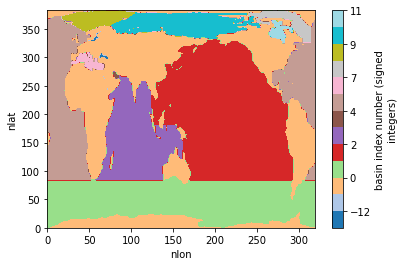

In [7]:
## File modified from https://pop-tools.readthedocs.io/en/latest/examples/region-mask.html
ocean_mask = xr.open_dataset("OceanMask.nc")
# ocean_mask['TLONG'] = ((ocean_mask.TLONG + 300) % 360) - 300

ocean_mask.REGION_MASK.plot.contourf(levels = np.array(np.unique(ocean_mask.REGION_MASK)), cmap = 'tab20')
###########################
## 1  Southern Ocean
## 2  Pacific Ocean
## 6  Atlantic Ocean + 8 + 11
## 10 Arctic Ocean

masks:
1. -80 to 80 (Arctic not included, without all southern ocean)
2. -80 to 80 (with the whole southern ocean)

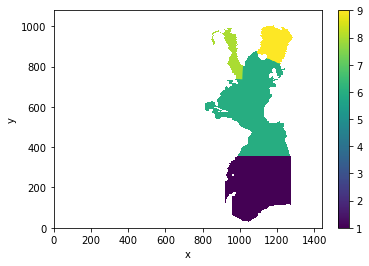

In [9]:
# Atlantic Ocean Mask 1 (80S to 80N)
mask_a = ocean_mask.where(ocean_mask.REGION_MASK.isin([6, 8]))
mask_b = ocean_mask.where(ocean_mask.REGION_MASK.isin([1]))
mask_b = xr.merge([mask_b.REGION_MASK.where(mask_b.TLONG < 20), mask_b.REGION_MASK.where(mask_b.TLONG >= 290)], compat="no_conflicts")
mask_c = ocean_mask.where(ocean_mask.REGION_MASK.isin([9]))
mask = xr.merge([mask_a, mask_b, mask_c], compat="no_conflicts")
mask = mask.rename({'TLONG': 'lon', 'TLAT': 'lat'})
ds_out = xr.Dataset({'lat': vgrid.lat, 'lon':vgrid.lon})
mask1 = func_regrid(mask.REGION_MASK, ds_out)
mask1.plot()

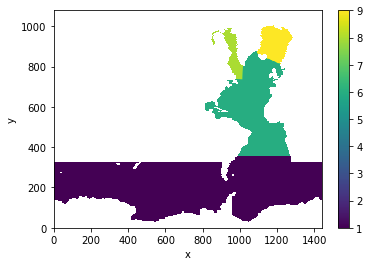

In [16]:
# Atlantic Ocean Mask 2 (80S to 80N all southern ocean) x doesn't make sense
mask_a = ocean_mask.where(ocean_mask.REGION_MASK.isin([6, 8]))
mask_b = ocean_mask.where(ocean_mask.REGION_MASK.isin([1]))
mask_b = xr.merge([mask_b.REGION_MASK.where(mask_b.TLONG <= 20), mask_b.REGION_MASK.where(mask_b.TLONG >= 290)], compat="no_conflicts")
mask_c = ocean_mask.where(ocean_mask.REGION_MASK.isin([9]))
mask_d = ocean_mask.where(ocean_mask.REGION_MASK.isin([1]))
mask_d = mask_d.where((mask_d.TLONG > 20) | (mask_d.TLONG < 290))
mask_d = mask_d.where(mask_d.TLAT < -40)
mask = xr.merge([mask_a, mask_b, mask_c, mask_d], compat="no_conflicts")
mask = mask.rename({'TLONG': 'lon', 'TLAT': 'lat'})
ds_out = xr.Dataset({'lat': vgrid.lat, 'lon':vgrid.lon})
mask2 = func_regrid(mask.REGION_MASK, ds_out)
mask2.plot()

In [22]:
def calc_dx(ds):
    ''' 
    This definition calculates the distance 
    between grid points that are in
    a latitude/longitude format.
    
    Using pyproj GEOD; different Earth Shapes 
    https://jswhit.github.io/pyproj/pyproj.Geod-class.html
    Common shapes: 'sphere', 'WGS84', 'GRS80'
    
    Accepts, 2D arrays for latitude and longitude
    
    Returns: dx, dy; 2D arrays of distances 
    between grid points in the x and y direction in meters
    ------------
    modified from:
    https://github.com/Unidata/MetPy/issues/288#issuecomment-279481555
    '''
    from pyproj import Geod
    
    g = Geod(ellps='sphere')
    
    lon = ds.lon.values
    lat = ds.lat.values
    
    dx = np.empty(ds.lon.shape)  
    
    for i in range(dx.shape[0]):
        for j in range(dx.shape[1]-1):
            _, _, dx[i,j] = g.inv(lon[i,j], lat[i,j], lon[i,j+1], lat[i,j+1])
    dx[:,j+1] = dx[:,j]
    
    return dx

In [25]:
da_vo = ds_vo_corrected.vo.where(~np.isnan(mask2), drop = True)

dz = ds_vo_corrected.lev_bnds[:,1] - ds_vo_corrected.lev_bnds[:,0]
dz = dz.load()

dx = calc_dx(da_vo)

vdzdx = da_vo * dz * dx / 1e6 # vdz *dx
V_dz = vdzdx.sum(dim = 'x') # int v from east to west : Vdz

stream = V_dz.cumsum(dim = 'lev') - V_dz.sum(dim = 'lev') # int from surf to depth h Vdz - int from surf to bottom V dz

stream_ann = stream.groupby('time.year').mean(dim='time', skipna=True)

stream30s = stream_ann.sel(y = slice(-30.5, -29.5)).mean(dim = 'y', skipna = True)

In [27]:
stream_avg = stream_ann.mean('year')

In [42]:
AMOC = stream_ann.sel(lev = slice(500,3000)).max('lev')
SMOC = stream_ann.sel(lev = slice(1000, 7000)).min('lev')

In [28]:
from dask_gateway import Gateway
gateway = Gateway()
# cluster = GatewayCluster()
options = gateway.cluster_options()

options.worker_cores = 4 # 16 #16 / 4
options.worker_memory = 16 # 32 #32 / 8  

cluster = gateway.new_cluster(options)

cluster.adapt(minimum = 2, maximum = 100)

client = cluster.get_client() 
cluster

In [39]:
stream30s = stream30s.load()

In [29]:
stream_avg = stream_avg.load()

In [43]:
AMOC = AMOC.load()

In [44]:
SMOC = SMOC.load()

In [48]:
stream30s.to_netcdf('streamfunction30s_cm4.nc')
AMOC.to_netcdf('AMOC_cm4.nc')
SMOC.to_netcdf('SMOC_cm4.nc')

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors

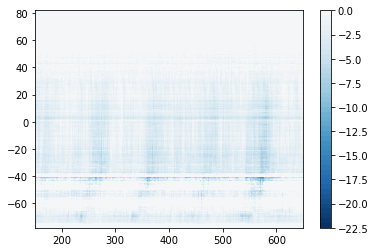

In [52]:
pltdata = SMOC
im = plt.contourf(pltdata.year, pltdata.y, pltdata.transpose(), 
                  levels = 50,cmap=plt.cm.RdBu_r, norm=colors.CenteredNorm())
# plt.gca().invert_yaxis()
cbar = plt.colorbar(im)#, extend='none')

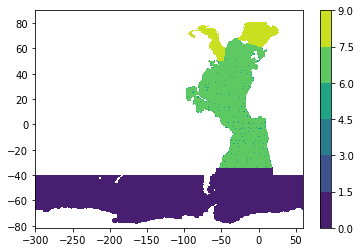

In [17]:
pltdata = mask2
im = plt.contourf(pltdata.lon, pltdata.lat, pltdata)#, levels = 50,cmap=plt.cm.RdBu_r) #, norm=divnorm, 
# plt.gca().invert_yaxis()
cbar = plt.colorbar(im)#, extend='none')

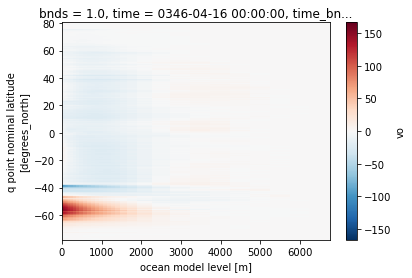

In [134]:
Stream.plot.pcolormesh()

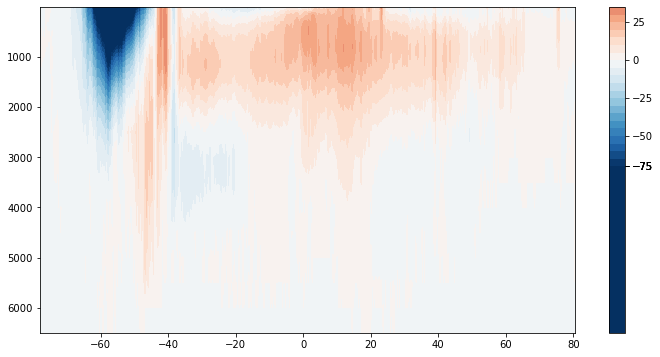

In [162]:
fig = plt.figure(figsize=(12,6))

divnorm = colors.TwoSlopeNorm(vmin=-70., vcenter=0, vmax=70)
im = plt.contourf(Stream.y, Stream.lev, Stream, levels = 50, norm=divnorm, cmap=plt.cm.RdBu_r) 
plt.gca().invert_yaxis()
# plt.xlabel('Year', fontsize=18)
# plt.ylabel('Depth (m)', fontsize=18)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
# plt.title('Temperature timeseries in Convection Area \n'+ plt_temp.region_name
#           + ', year ' + str(start_year)+'-'+str(end_year)+', '+model_name, fontsize=18)
cbar = plt.colorbar(im, extend='none')
# cbar.set_label('$^{\circ}$C', fontsize=18, rotation=0, horizontalalignment = 'left')
# cbar.ax.tick_params(labelsize=15) 
# fig.savefig('test2.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

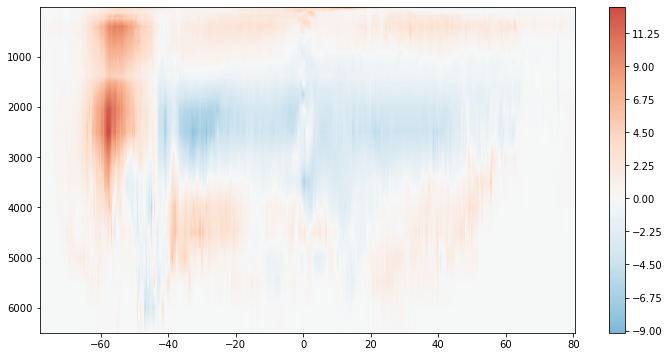

In [169]:
fig = plt.figure(figsize=(12,6))

divnorm = colors.TwoSlopeNorm(vmin=-20., vcenter=0, vmax=20)
im = plt.contourf(V_dz.y, V_dz.lev, V_dz, levels = 500, norm=divnorm, cmap=plt.cm.RdBu_r) 
plt.gca().invert_yaxis()
# plt.xlabel('Year', fontsize=18)
# plt.ylabel('Depth (m)', fontsize=18)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
# plt.title('Temperature timeseries in Convection Area \n'+ plt_temp.region_name
#           + ', year ' + str(start_year)+'-'+str(end_year)+', '+model_name, fontsize=18)
cbar = plt.colorbar(im, extend='max')
# cbar.set_label('$^{\circ}$C', fontsize=18, rotation=0, horizontalalignment = 'left')
# cbar.ax.tick_params(labelsize=15) 
# fig.savefig('test2.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
# find the depth of maximum streamfunction (AMOC at 30S ) & the minimum streamfunction (SMOC at 30S)
# find the depth of fo streamfucntion of 0. 
# intergral between the depth of AMOC & SMOC (to check if they equal the sum of SMOC & AMOC (should be))

Heuze 2020

for GFDL CM4 

Table B2 SMOC at 30 S 3.0 +- 2.4 Sv

Table B1 AMOC at 35 N 8.9 +- 10.7 Sv

In [172]:
Stream.sel(y = -30, method = 'nearest')

<xarray.DataArray 'vo' (lev: 35)>
array([ 1.35292653,  0.98929857,  0.96507127,  1.18681432,  2.00881562,
        2.70013785,  3.27904114,  3.84287406,  4.68027713,  5.78818153,
        6.8384015 ,  8.20841911, 10.03600972, 11.9481297 , 13.64523256,
       15.00283033, 16.1105823 , 16.9604895 , 17.66872942, 18.13285945,
       18.27039202, 18.01409671, 17.36737845, 15.50150476, 12.03258486,
        5.59858809, -1.89746409, -6.21184985, -7.50748552, -4.411281  ,
       -1.45182325,  0.        ,  0.        ,  0.        ,  0.        ])
Coordinates:
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    time     object 0213-02-15 00:00:00
    y        float64 -29.92

In [173]:
V_dz.sel(y = -30, method = 'nearest')

<xarray.DataArray 'vo' (lev: 35)>
array([-0.27466628, -0.36362796, -0.0242273 ,  0.22174304,  0.8220013 ,
        0.69132223,  0.57890329,  0.56383292,  0.83740307,  1.10790441,
        1.05021997,  1.37001761,  1.8275906 ,  1.91211998,  1.69710286,
        1.35759777,  1.10775197,  0.8499072 ,  0.70823992,  0.46413003,
        0.13753258, -0.25629531, -0.64671827, -1.86587369, -3.46891989,
       -6.43399678, -7.49605218, -4.31438576, -1.29563567,  3.09620452,
        2.95945775,  1.45182325,  0.        ,  0.        ,  0.        ])
Coordinates:
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    time     object 0213-02-15 00:00:00
    y        float64 -29.92

In [170]:
client.close()
cluster.close()